In [ ]:
import pandas as pd
import altair as alt
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline


In [2]:
# Reading pre-filtered Case Date
us_delta = pd.read_csv('./us_july_15-present.csv', index_col = 0)

# Scaling Cases
us_delta.Cumulative_cases /= 1000
us_delta.new_cumulative_cases /= 1000

# Adjusting Time columns
us_delta.Date_reported = pd.to_datetime(us_delta.Date_reported, format = '%Y-%m-%d')
us_delta['t'] = us_delta.Date_reported - us_delta.Date_reported.min()
us_delta['t'] = us_delta.t.dt.days

# Filtering cases to include only days up to peak in early september
us_delta = us_delta.loc[us_delta.Date_reported < pd.Timestamp('09-03-2021')]

In [3]:
us_delta.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,new_cumulative_cases,t
157404,2021-07-16,US,United States of America,AMRO,38361,33812.685,338,604296,0.000,0
157405,2021-07-17,US,United States of America,AMRO,40447,33853.132,336,604632,40.447,1
157406,2021-07-18,US,United States of America,AMRO,42185,33895.317,383,605015,82.632,2
157407,2021-07-19,US,United States of America,AMRO,31321,33926.638,184,605199,113.953,3
157408,2021-07-20,US,United States of America,AMRO,28236,33954.874,154,605353,142.189,4


In [4]:
alt.Chart(
    us_delta[['Date_reported', 'new_cumulative_cases']]
).mark_line().encode(
    x = 'Date_reported:T', 
    y = 'new_cumulative_cases'
)

alt.Chart(...)

In [5]:
cases = us_delta.new_cumulative_cases.values
t = us_delta.t.values

In [6]:
with pm.Model() as init_model:
    # Intercept
    a = pm.Normal('a', mu = 0, sigma = 100)

    # Slope
    b = pm.Normal('b', mu = .3, sigma = 0.3)

    # Exponential regression
    growth = a * (1+b)** t

    # Errors
    e = pm.HalfNormal('e', 100)

    # Likelihood
    pm.Normal('obs',mu= growth, sigma = e, observed = cases)

obs ~ Normal

In [7]:
with init_model:
    init_prior_pred = pm.sample_prior_predictive()

In [95]:
for var, tensor in init_prior_pred.items():
    print(var, ': ', tensor.shape)

e :  (500,)
a :  (500,)
e_log__ :  (500,)
obs :  (500, 49)
b :  (500,)


In [31]:
prior_obs = pd.DataFrame(init_prior_pred['obs'].T)
prior_obs_long = prior_obs.reset_index().melt('index', var_name = 'series', value_name = 'obs')
prior_obs_long.columns = ['t', 'series', 'cases']
prior_obs_long.loc[
    (prior_obs_long.series < 150) & 
    (prior_obs_long.t < 10) &
    (prior_obs_long.cases != 0)
] 

,t,series,cases
0,0,0,-81.084606
1,1,0,-99.548024
2,2,0,-71.009207
3,3,0,-145.100560
4,4,0,-139.324882
...,...,...,...
7306,5,149,1881.779636
7307,6,149,3936.240936
7308,7,149,8034.643287
7309,8,149,16058.416068


In [37]:
alt.Chart( 
    prior_obs_long.loc[
        (prior_obs_long.series < 150) & 
        (prior_obs_long.t < 10) &
        (prior_obs_long.cases != 0)
    ] 
).mark_line().encode(
    alt.X('t'),
    alt.Y(
        'cases', 
        scale = alt.Scale(
            # type = 'log', 
            # domain = (-1e5, 1e5)
        ), 
        axis = alt.Axis(tickCount = 5)
    ),
    detail = 'series',
    opacity = alt.value(0.2),
    color = alt.value('grey')
)

alt.Chart(...)

In [38]:
with init_model:
    init_trace = pm.sample(tune = 0, draws = 500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e, b, a]


Sampling 4 chains for 0 tune and 500 draw iterations (0 + 2_000 draws total) took 0 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for s

/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite value

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5277cc0c40>,
      dtype=object)

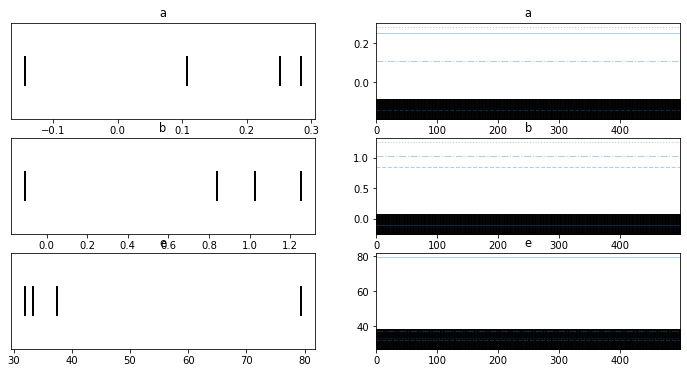

In [39]:
az.plot_trace(init_trace)

In [40]:
with pm.Model() as improved_model:
    # Intercept - Can't have negative cumulative cases
    a = pm.HalfNormal('a', sigma = 100) 

    # Slope
    b = pm.Normal('b', mu = .3, sigma = 0.1)

    # Exponential regression
    growth = a * (1+b)** t

    # Likelihood
    pm.NegativeBinomial(
        'obs', 
        mu = growth, 
        alpha = pm.Gamma('alpha', mu = 6, sigma = 1),
        observed = cases)

obs ~ NegativeBinomial

In [41]:
with improved_model:
    improved_prior_pred = pm.sample_prior_predictive()

prior_obs = pd.DataFrame(improved_prior_pred['obs'].T)
prior_obs_long = prior_obs.reset_index().melt('index', var_name = 'series', value_name = 'obs')
prior_obs_long.columns = ['t', 'series', 'cases']

alt.Chart( prior_obs_long.loc[prior_obs_long['t'] <=10] ).mark_line().encode(
    alt.X('t'),
    alt.Y(
        'cases', 
        scale = alt.Scale(type = 'log', domain = (1, 100_000)), 
        axis = alt.Axis(tickCount = 5)
    ),
    detail = 'series',
    opacity = alt.value(0.2),
    color = alt.value('grey')
)

DataTransformerRegistry.enable('default')

alt.Chart(...)

In [42]:
improved_prior_pred['obs'].shape

(500, 49)

In [43]:
with improved_model:
    improved_trace = pm.sample(chains = 4, cores = 4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8922988607345874, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f526f66b460>,
      dtype=object)

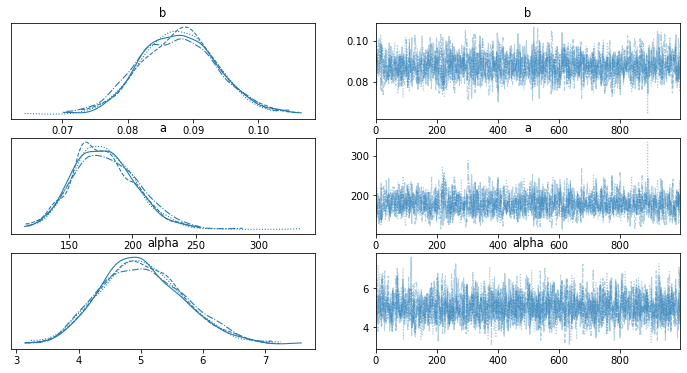

In [44]:
az.plot_trace(improved_trace)

In [45]:
az.summary(improved_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.088,0.006,0.077,0.098,0.000,0.000,1555.0,1653.0,1.0
a,178.218,24.652,133.066,223.861,0.610,0.431,1614.0,1672.0,1.0
alpha,5.028,0.671,3.835,6.305,0.015,0.010,2138.0,1974.0,1.0


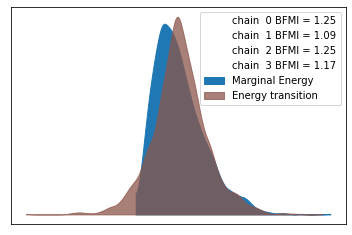

In [46]:
az.plot_energy(improved_trace)

In [47]:
with improved_model:
    improved_post_pred = pm.sample_posterior_predictive(improved_trace.posterior)

In [52]:
post_obs = pd.DataFrame(improved_post_pred['obs'].T)
post_obs_long = post_obs.reset_index().melt('index', var_name = 'series', value_name = 'obs')
post_obs_long.columns = ['t', 'series', 'cases']
post_obs_long.loc[post_obs_long.series < 100] 


,t,series,cases
0,0,0,252
1,1,0,181
2,2,0,205
3,3,0,259
4,4,0,94
...,...,...,...
4895,44,99,8527
4896,45,99,3706
4897,46,99,11546
4898,47,99,4447


In [53]:
posterior_pred_chart = alt.Chart( 
    post_obs_long.loc[post_obs_long.series < 100] 
).mark_line().encode(
    alt.X('t'),
    alt.Y(
        'cases', 
        scale = alt.Scale(type = 'log', domain = (1, 100_000)), 
        axis = alt.Axis(tickCount = 5)
    ),
    detail = 'series',
    opacity = alt.value(0.2),
    color = alt.value('grey')
)

observed_line = alt.Chart(
    us_delta.loc[us_delta.new_cumulative_cases !=0,['t', 'new_cumulative_cases']]
).mark_line().encode(
    alt.Y(
        'new_cumulative_cases', 
        scale = alt.Scale(type = 'log', domain = (1, 100_000)),
        axis = alt.Axis(tickCount = 5)
    ),
    alt.X('t'),
    # y = 'new_cumulative_cases'
)

posterior_pred_chart + observed_line
# posterior_pred_chart

alt.LayerChart(...)

In [54]:
residuals = improved_post_pred['obs'].T \
- us_delta[['new_cumulative_cases']].values

In [56]:
resid_long = pd.DataFrame(residuals).reset_index().melt('index', var_name = 'series', value_name='obs')
resid_long.columns = ['t', 'series', 'cases']
resid_long.loc[resid_long.series < 100]

,t,series,cases
0,0,0,252.000
1,1,0,140.553
2,2,0,122.368
3,3,0,145.047
4,4,0,-48.189
...,...,...,...
4895,44,99,3799.713
4896,45,99,-1172.071
4897,46,99,6550.161
4898,47,99,-683.122


In [67]:
improved_resids_chart = alt.Chart(
    resid_long.loc[
        (resid_long.series < 100)
    ]
 ).mark_line().encode(
    alt.X('t'),
    alt.Y(
        'cases', 
        scale = alt.Scale(
        ), 
        axis = alt.Axis(tickCount = 5)
    ),
    detail = 'series',
    opacity = alt.value(0.2),
    color = alt.value('grey')
)

improved_resids_chart


alt.Chart(...)

In [68]:
with pm.Model() as improved_2_model:
    # Creating pymc3 data objects
    t_data = pm.Data('t', t)
    cases_data = pm.Data('cases', cases)

    # Intercept - Can't have negative cumulative cases
    #   By Definition, at time = 0, we should have no cases
    intercept = pm.HalfNormal('intercept', sigma = 100) 

    # Slope - Modeling Cumulative cases: Can't have negative slope.
    beta = pm.Bound(pm.Normal, lower = 0)(
        'beta', mu = .3, sigma = 0.1
    )

    # Exponential regression
    growth = intercept * (1+beta)** t

    # Likelihood
    pm.NegativeBinomial(
        'obs', 
        mu = growth, 
        alpha = pm.Gamma('alpha', mu = 6, sigma = 1),
        observed = cases)
    


obs ~ NegativeBinomial

In [69]:
with improved_2_model:
    improved_2_trace = pm.sample(chains = 4, cores = 4, return_inferencedata=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.889506971754114, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5277d73790>,
      dtype=object)

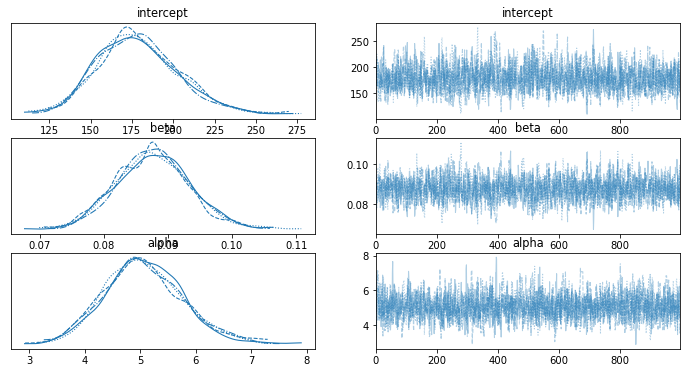

In [70]:
az.plot_trace(improved_2_trace)

In [71]:
az.summary(improved_2_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,178.707,24.101,135.214,224.247,0.585,0.415,1695.0,1780.0,1.0
beta,0.088,0.006,0.077,0.098,0.000,0.000,1737.0,1655.0,1.0
alpha,5.068,0.707,3.694,6.334,0.016,0.012,1980.0,1479.0,1.0


In [72]:
with improved_2_model:
    pm.set_data({'t': np.arange(96), 'cases': np.zeros(96, dtype='int')})

    improved_2_post_pred = pm.sample_posterior_predictive(improved_2_trace)

In [73]:
post_obs = pd.DataFrame(improved_2_post_pred['obs'].T)
post_obs_long = post_obs.reset_index().melt('index', var_name = 'series', value_name = 'obs')
post_obs_long.columns = ['t', 'series', 'cases']

post_obs_long.loc[
    post_obs_long.series < 100
]

,t,series,cases
0,0,0,257
1,1,0,340
2,2,0,98
3,3,0,257
4,4,0,256
...,...,...,...
4895,44,99,4082
4896,45,99,7081
4897,46,99,4377
4898,47,99,6547


In [74]:


posterior_pred_chart = alt.Chart(
    post_obs_long.loc[
        post_obs_long.series < 100
    ]
).mark_line().encode(
    alt.X('t'),
    alt.Y(
        'cases', 
        scale = alt.Scale(type = 'log', domain = (1, 100_000)), 
        axis = alt.Axis(tickCount = 5)
    ),
    detail = 'series',
    opacity = alt.value(0.2),
    color = alt.value('grey')
)

observed_line = alt.Chart(
    us_delta.loc[us_delta.new_cumulative_cases != 0,['t', 'new_cumulative_cases']]
).mark_line().encode(
    alt.Y(
        'new_cumulative_cases', 
        scale = alt.Scale(type = 'log', domain = (1, 100_000)),
        axis = alt.Axis(tickCount = 5)
    ),
    alt.X('t'),
)

posterior_pred_chart + observed_line
# posterior_pred_chart

alt.LayerChart(...)

In [105]:
with pm.Model() as logistic_model:
    # Creating pymc3 data objects
    t_data = pm.Data('t', t)
    cases_data = pm.Data('cases', cases)

    # Intercept - Can't have negative cumulative cases
    #   By Definition, at time = 0, we should have no cases
    intercept = pm.HalfNormal('intercept', sigma = 100) 

    # Slope - Modeling Cumulative cases: Can't have negative slope.
    beta = pm.Bound(pm.Normal, lower = 0)(
        'beta', mu = .3, sigma = 0.1
    )

    # Set Limits for logistic growth function
    #   Lower limit is 0, upper limit is roughly the US population
    limits = pm.Uniform('limits', lower = 0, upper = 331_500)
    
    # Logistic regression - however not for classification
    a = limits / intercept - 1
    growth = limits / (1 + a * pm.math.exp(-beta * t_data))

    # Likelihood
    pm.NegativeBinomial(
        'obs', 
        mu = growth, 
        alpha = pm.Gamma('alpha', mu = 6, sigma = 1),
        observed = cases)
    

    

obs ~ NegativeBinomial

In [106]:
with logistic_model:
    logistic_prior_pred = pm.sample_prior_predictive()

In [107]:
for var, tensor in logistic_prior_pred.items():
    print(var, ': ', tensor.shape)

limits :  (500,)
alpha_log__ :  (500,)
alpha :  (500,)
intercept_log__ :  (500,)
obs :  (500, 500, 49)
beta :  (500, 1)
limits_interval__ :  (500,)
intercept :  (500,)
beta_lowerbound__ :  (500, 1)


In [108]:
with logistic_model:
    logistic_trace = pm.sample(chains = 4, cores = 4, return_inferencedata=True, target_accept = .9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, limits, beta, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [112]:
with logistic_model:
    logistic_post_pred = pm.sample_posterior_predictive(logistic_trace.posterior)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f523149bd60>,
      dtype=object)

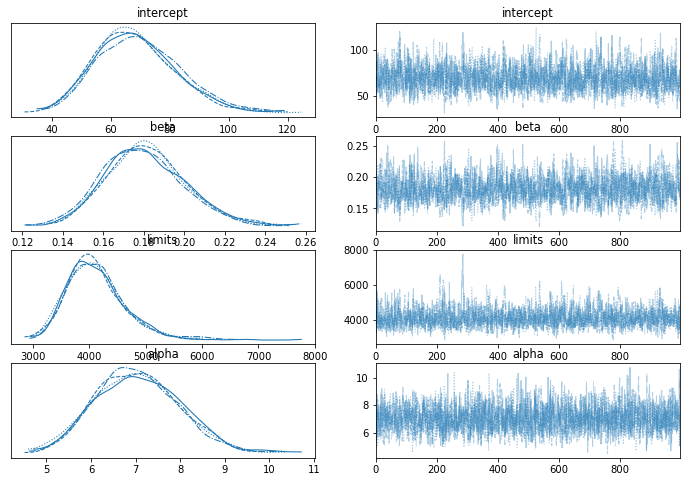

In [110]:
az.plot_trace(logistic_trace)

In [111]:
az.summary(logistic_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,68.835,13.784,43.962,94.711,0.368,0.262,1413.0,1774.0,1.0
beta,0.181,0.020,0.145,0.220,0.001,0.000,1361.0,1734.0,1.0
limits,4120.288,517.206,3182.704,5051.440,13.311,9.834,1763.0,1404.0,1.0
alpha,7.050,0.937,5.314,8.767,0.019,0.014,2363.0,2494.0,1.0


In [113]:
post_obs = pd.DataFrame(logistic_post_pred['obs'].T)
post_obs_long = post_obs.reset_index().melt('index', var_name = 'series', value_name = 'obs')
post_obs_long.columns = ['t', 'series', 'cases']

post_obs_long.loc[
    post_obs_long.series < 100
]

,t,series,cases
0,0,0,81
1,1,0,170
2,2,0,124
3,3,0,159
4,4,0,126
...,...,...,...
4895,44,99,2710
4896,45,99,5826
4897,46,99,2437
4898,47,99,2774


In [115]:
posterior_pred_chart = alt.Chart(
    post_obs_long.loc[
        post_obs_long.series < 100
    ]
).mark_line().encode(
    alt.X('t'),
    alt.Y(
        'cases', 
    ),
    detail = 'series',
    opacity = alt.value(0.2),
    color = alt.value('grey')
)

observed_line = alt.Chart(
    us_delta.loc[us_delta.new_cumulative_cases != 0,['t', 'new_cumulative_cases']]
).mark_line().encode(
    alt.Y(
        'new_cumulative_cases', 
    ),
    alt.X('t'),
)

posterior_pred_chart + observed_line

alt.LayerChart(...)

In [117]:
with improved_2_model:
    pm.set_data({'t': t, 'cases': cases})
    improved_2_trace_full = pm.sample(chains = 4, cores = 4, return_inferencedata=True,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
logistic_resids_chart = alt.Chart(
    resid_long.loc[
        (resid_long.series < 100)
    ]
 ).mark_line().encode(
    alt.X('t'),
    alt.Y(
        'cases', 
        scale = alt.Scale(
        ), 
        axis = alt.Axis(tickCount = 5)
    ),
    detail = 'series',
    opacity = alt.value(0.2),
    color = alt.value('grey')
)

logistic_resids_chart


In [118]:
az.compare({
    'exponential': improved_2_trace, 
    'logistic': logistic_trace
})

/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/alexkeeney/anaconda3/envs/bs/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
logistic,0,-370.835386,4.865442,0.000000,1.0,13.570688,0.000000,True,log
exponential,1,-390.379139,5.644875,19.543753,0.0,14.294728,3.407468,True,log
